# SITH Demo

### Authors: Brandon G. Jacques and Per B. Sederberg

## Overview

Here we demonstrate some of the basic properties of the Scale Invariant Temporal History (SITH) model.

In [1]:
%matplotlib inline

In [6]:

# imports
import random
import math

import numpy as np
import scipy
import scipy.misc
import scipy.integrate
import pandas as pd

import torch

import torch.nn
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using:', device)
if device == 'cuda':
    torchtypes=torch.cuda
    usecuda=True
else:
    torchtypes=torch
    usecuda=False

import seaborn as sns
import matplotlib.pyplot as plt
# import matplotlib.patheffects

from sith import SITH

import seaborn as sn
sn.set_context("talk")

Using: cpu


# Test 1: Basic signal through time. 

We are testing a SITH setup on a 1 second scale and adding in an input signal 
that occurs for one time step and viewing what that singal looks like through 
time in both Lapace space and inverse-Lapace space. 

In [4]:
#        The SITH layer, can take in direct input in the form of 
#        (1, sequence_len, features, 2) or bit wise input (1, sequence_len, features, 1)
#
#        Parameters
#        ----------
#            in_features: int
#                Number of tracked features
#            tau_min: float (default = 1)
#                The center of the FIRST receptive field in inverse-Lapace space. The
#                presentation time of each stimulus.
#            tau_max: float (default = 20)
#                The center of the LAST receptive field in inverse-Lapace space. The
#                presentation time of each stimulus.
#            k: int (default = 4)
#                The spcificity of the receptive fields
#            g: float (defaut = 1.0)
#                Indicates whether to scale the output by taustar, keeping activation
#                level the same across taustar
#            alpha: float (default = 1.0)
#                Rate of change in Laplace domain.
#            ntau: int (default = 100)
#                The desired number of taustars in the final representation, before
#                indexing with T_every
#
#
#############################################################################


sith_params ={"in_features":10,
              "tau_min":1, "tau_max":100,
              "k":4,
              "g":0.0,
              "ntau":100,  
              "T_every":8, 
              "alpha":1.0,
              "ttype":torchtypes.DoubleTensor}

sithrep = SITH(**sith_params)
target_vec = torch.ones(1, 10).type(torchtypes.DoubleTensor)
taustars = sithrep.tau_star.detach().cpu().numpy()
print(taustars)

[ 1.          1.45082878  2.10490414  3.05385551  4.43062146  6.42807312
  9.32603347 13.53047775 19.6304065  28.48035868 41.320124   59.94842503
 86.97490026]


In [12]:
def safecuda(oo):
    if usecuda:
        return oo.cuda()
    else:
        return oo

In [13]:
target_vecs = torch.cat((target_vec, 
                         safecuda(torch.zeros(39,10).type(torch.DoubleTensor))), 
                        dim=0)
print(target_vecs.shape)

torch.Size([40, 10])


Text(0.5, 1.0, 'One feature through time')

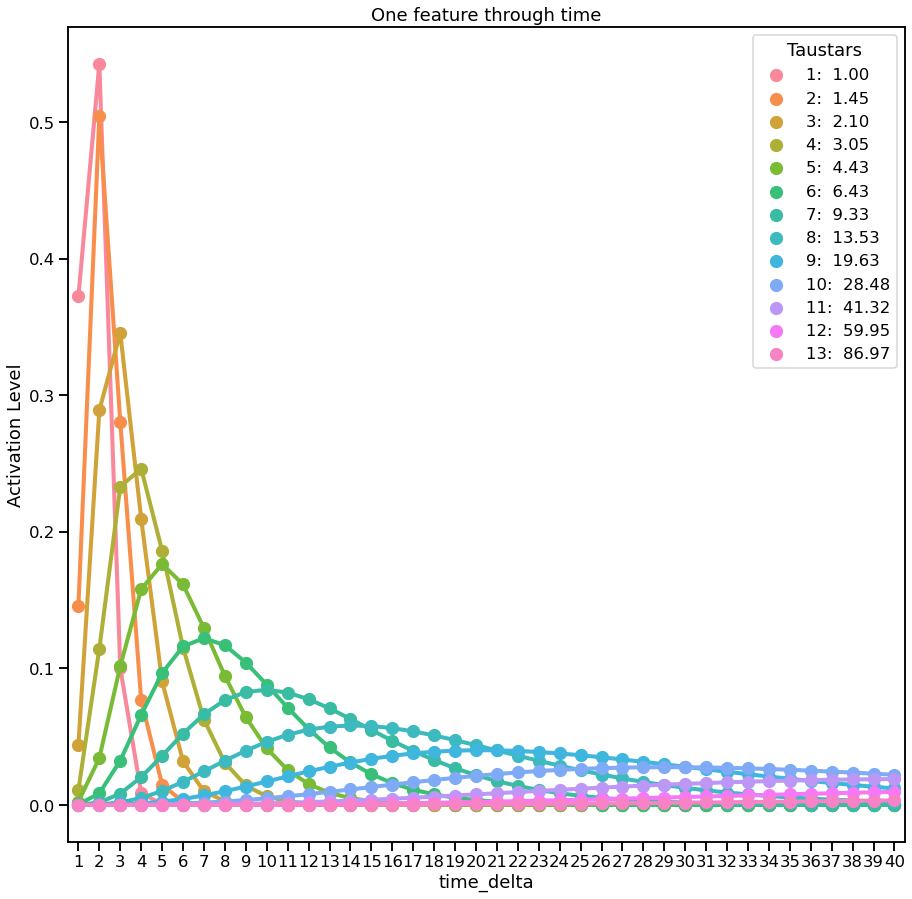

In [14]:
sithrep.reset()
dat = {"Taustars":[],
       "data":[],
       "time_delta":[]}

Ts = sithrep(target_vecs)
x = 0
for T in Ts.split(1,dim=0):
    for i in range(len(taustars)):
        dat["Taustars"].append("%i:  %.2f" % (i+1,taustars[i]))
        dat['time_delta'].append(x+1)
        dat['data'].append(T.detach().cpu().numpy()[0, i, 0])
    x += 1
sdat = pd.DataFrame(dat)
fig = plt.figure(figsize=(15,15))
a = sn.pointplot(data=sdat, hue="Taustars", x="time_delta", y="data")
a.set_ylabel("Activation Level")
a.set_title("One feature through time")

In [15]:
sith_params ={"in_features":10,
              "tau_min":1, "tau_max":100,
              "k":10,
              "g":1.0,
              "ntau":100,  
              "T_every":8, 
              "alpha":1.0,
              "ttype":torchtypes.DoubleTensor}

sithrep = SITH(**sith_params)
safecuda(sithrep)
target_vec = torch.ones(1, 10).type(torchtypes.DoubleTensor)
taustars = sithrep.tau_star.detach().cpu().numpy()
input_scale = 10
print(taustars)

[ 1.          1.45082878  2.10490414  3.05385551  4.43062146  6.42807312
  9.32603347 13.53047775 19.6304065  28.48035868 41.320124   59.94842503
 86.97490026]


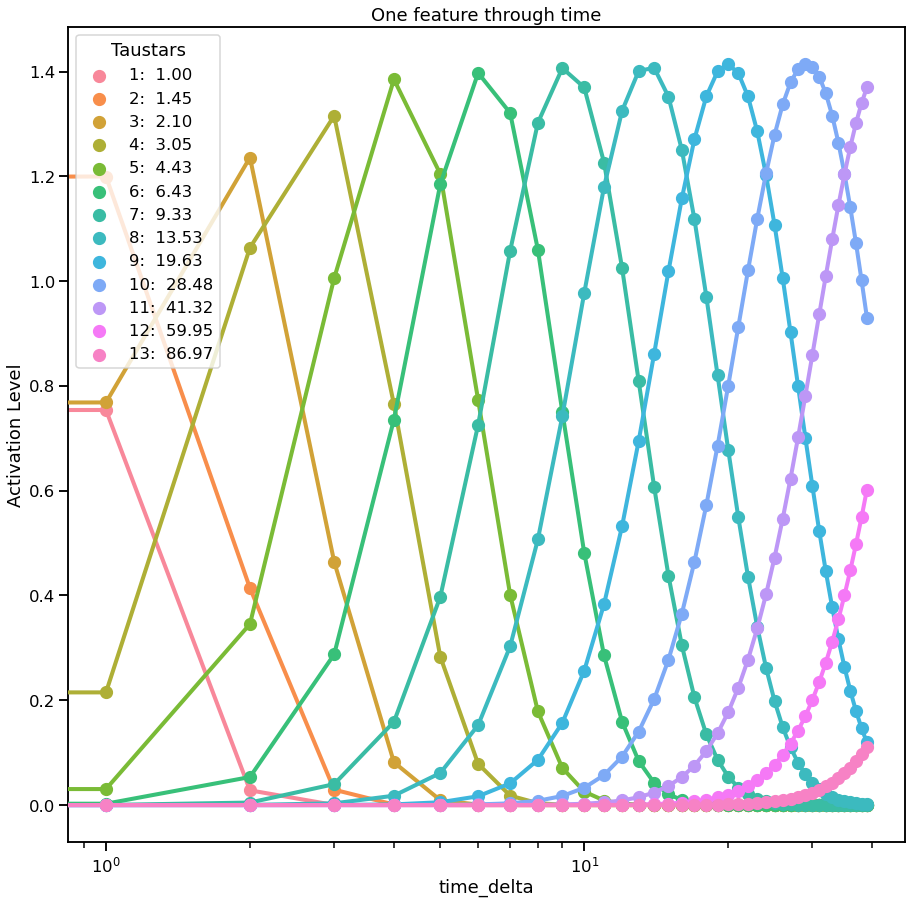

In [16]:
sithrep.reset()
dat = {"Taustars":[],
       "data":[],
       "time_delta":[]}

Ts = sithrep(target_vecs)
x = 0
for T in Ts.split(1,dim=0):
    for i in range(len(taustars)):
        dat["Taustars"].append("%i:  %.2f" % (i+1,taustars[i]))
        dat['time_delta'].append(x+1)
        dat['data'].append(T.detach().cpu().numpy()[0, i, 0])
    x += 1
sdat = pd.DataFrame(dat)
fig = plt.figure(figsize=(15,15))
a = sn.pointplot(data=sdat, hue="Taustars", x="time_delta", y="data")
a.set_ylabel("Activation Level")
a.set_title("One feature through time")
plt.xscale("log")

#  Test 2: two inputs

In [17]:
sith_params ={"in_features":1,
              "tau_min":1, "tau_max":1000,
              "k":10,
              "g":0.0,
              "ntau":200,  
              "T_every":8, 
              "alpha":1.0,
              "ttype":torchtypes.DoubleTensor}

sithrep = SITH(**sith_params)
safecuda(sithrep)
target_vec = torch.ones(1, sith_params['in_features']).type(torchtypes.DoubleTensor)
taustars = sithrep.tau_star.detach().cpu().numpy()
input_scale = 10
print(taustars)

[  1.           1.3200884    1.74263339   2.30043012   3.03677112
   4.00880633   5.29197874   6.98587975   9.22197882  12.17382728
  16.07052818  21.21451785  28.00503894  36.96912707  48.80251584
  64.42363509  85.04489342 112.26677735 148.20207058 195.63983435
 258.26187607 340.92850697 450.05576757 594.1133985  784.28220613]


In [18]:
target_vecs = torch.cat((target_vec, 
                         safecuda(torch.zeros(10,sith_params['in_features']).type(torch.DoubleTensor)),
                         target_vec,
                         safecuda(torch.zeros(26,sith_params['in_features']).type(torch.DoubleTensor)),), 
                        dim=0)
print(target_vecs.shape)

torch.Size([38, 1])


Text(0.5, 1.0, 'One feature through time')

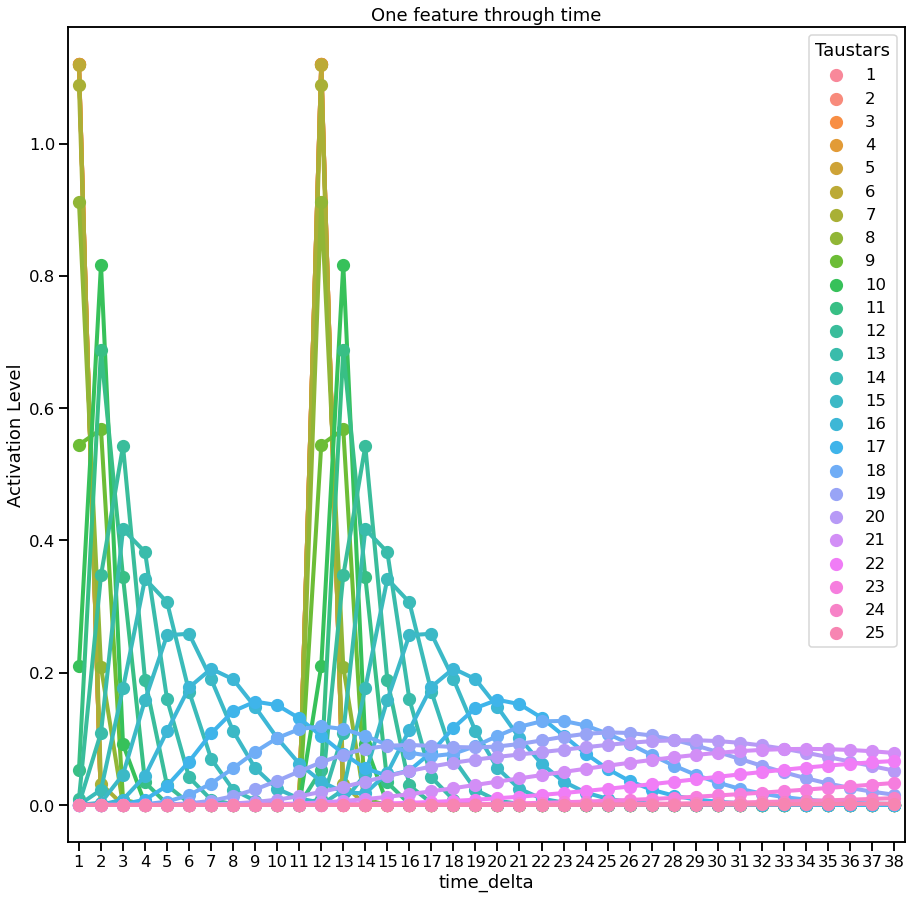

In [19]:
sithrep.reset()
dat = {"Taustars":[],
       "data":[],
       "time_delta":[]}

Ts = sithrep(target_vecs, dur=10)
x = 0
for T in Ts.split(1,dim=0):
    for i in range(len(taustars)):
        dat["Taustars"].append(i+1)
        dat['time_delta'].append(x+1)
        dat['data'].append(T.detach().cpu().numpy()[0, i, 0])
    x += 1
sdat = pd.DataFrame(dat)
fig = plt.figure(figsize=(15,15))
a = sn.pointplot(data=sdat, hue="Taustars", x="time_delta", y="data")
a.set_ylabel("Activation Level")
a.set_title("One feature through time")


Text(0.5, 0.92, 'ftilde2 as a function of dts')

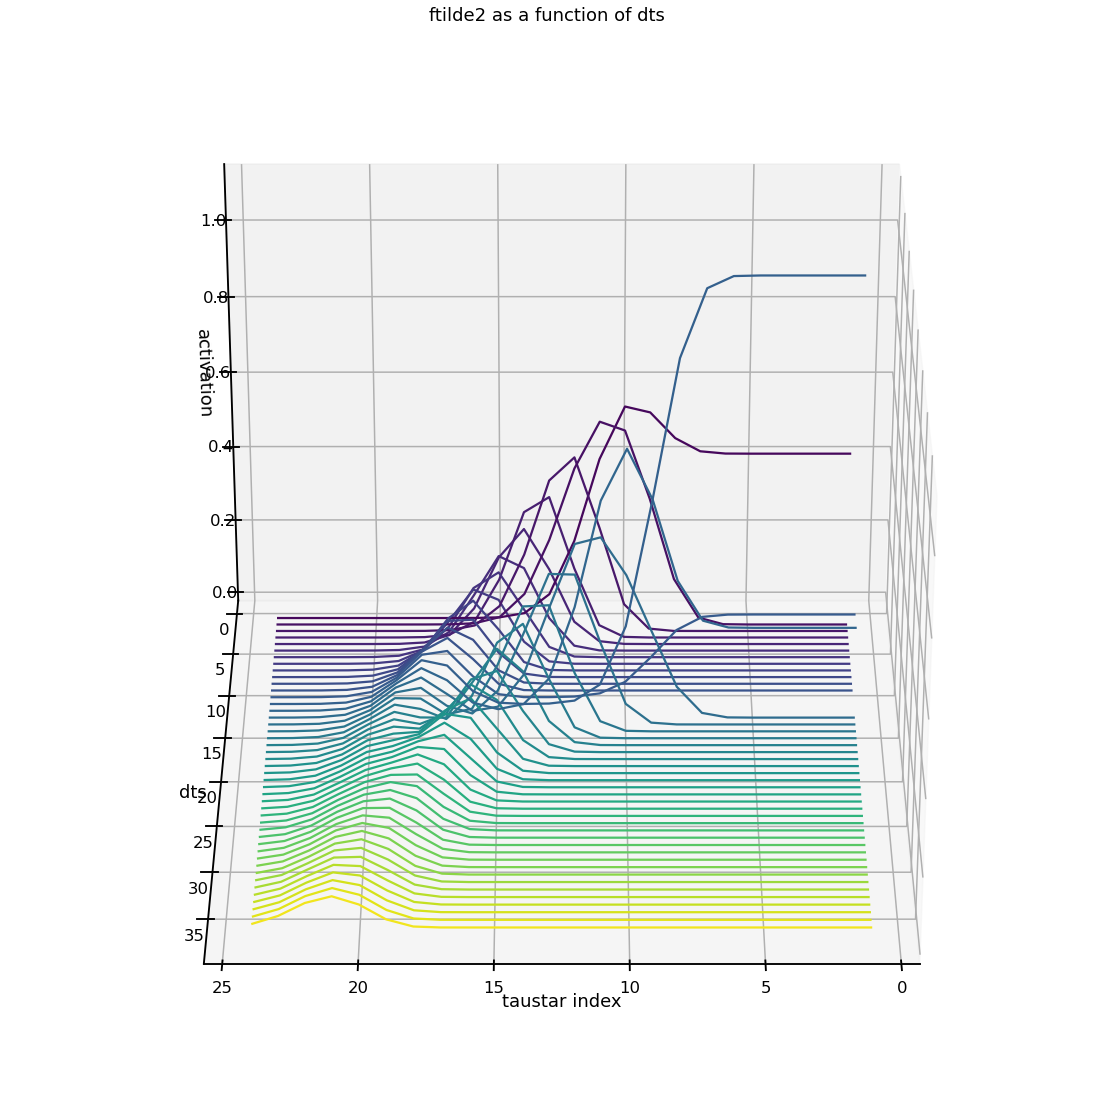

In [20]:

from mpl_toolkits.mplot3d import axes3d, Axes3D
fig = plt.figure(figsize=(15,15))
def f(x, y):
    return float(sdat.loc[(sdat.Taustars==int(x))&(sdat.time_delta==int(y)), "data"])

x = list(range(1,max(sdat.Taustars)))
y = list(range(1,max(sdat.time_delta)))
Z = []
for X in x:
    Z.append([])
    for Y in y:
        Z[-1].append(f(X, Y))
X, Y = np.meshgrid(x, y)
Z = np.array(Z).transpose(1,0)

ax = Axes3D(fig)
ax.contour3D(X, Y, Z, 50,zdir="y", cmap='viridis')
ax.view_init(30,90)
ax.set_xlabel("taustar index")
ax.set_ylabel("dts")
ax.set_zlabel("activation")
ax.set_title("ftilde2 as a function of dts")